**관세청 수출입 무역 통계 에서 가공한 데이터**  
- 특정 국가에 대한 월별 수출입 건수와 금액(단위:천 불(USD 1,000)  
- 무역수지 = 수출금액-수입금액
- 학습 목표  
  1. 중복된 데이터를 찾아 제거, 결측치(missing data)를 제거하거나 채움
  2. 데이터를 정규화  
  3. 이상치(outlier)를 찾고 처리  
  4. 범주형 데이터를 원-핫 인코딩  
  5. 연속적인 데이터를 구간으로 나눠 범주형 데이터로 변환  
- 학습 목차
 1. 결측치(Missing Data)
 2. 중복된 데이터
 3. 이상치(Outlier)
 4. 정규화(Normalization)
 5. 원-핫 인코딩(One-Hot Encoding)
 6. 구간화(Binning)

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

csv_file_path = os.getenv('HOME')+'/aiffel/data_preprocess/data/trade.csv'
trade = pd.read_csv(csv_file_path) 
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지,기타사항
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0,NaN
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0,NaN
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0,NaN
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0,NaN
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0,NaN


In [216]:
type(trade) ## CSV 는 DF

pandas.core.frame.DataFrame

## 결측치

In [217]:
# 전체 데이터 건수에서 각 컬럼별 값이 있는 데이터 수를 빼주면 컬럼별 결측치의 개수를 알 수 있습니다.
# 결측치 여부

print('전체 데이터 건수:', len(trade))
print('컬럼별 결측치 개수')
len(trade) - trade.count() ## 동일코드: trade.isnull().sum() 

전체 데이터 건수: 199
컬럼별 결측치 개수


기간        0
국가명       0
수출건수      3
수출금액      4
수입건수      3
수입금액      3
무역수지      4
기타사항    199
dtype: int64

In [218]:

# 기타사항은 전부 결측값으로 제외

trade = trade.drop('기타사항', axis=1)
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0


In [219]:
# 결측치 여부를 각 컬럼마다  T-F 로 확인
# DataFrame.isnull()은 데이터마다 결측치 여부를 True, False로 반환합니다. 

trade.isnull()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
194,False,False,False,False,False,False,False
195,False,False,False,False,False,False,False
196,False,False,True,True,True,True,True
197,False,False,True,True,True,True,True


In [220]:
# DataFrame.any(axis=1)는 행마다 하나라도 True가 있으면 True, 그렇지 않으면 False를 반환
#칼럼이 너무 많아서 보기 불편하다면, null값이 있는 칼럼명만 뽑아 확인.

# axis=0 이면 열마다 결측치를 확인, axis=1 이면 행마다 결측치를 확인
trade.isnull().any(axis=1)

# sum()대신 any()를 활용
#trade.isnull().any(axis=1)

0      False
1      False
2      False
3      False
4      False
       ...  
194    False
195    False
196     True
197     True
198     True
Length: 199, dtype: bool

In [221]:
# trade.isnull().any(axis=1)을 다시 DataFrame에 넣어주면 값이 True인 데이터만 추출

trade[trade.isnull().any(axis=1)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,NaN,1141118.0,5038739.0,NaN
196,2020년 06월,중국,NaN,NaN,NaN,NaN,NaN
197,2020년 06월,미국,NaN,NaN,NaN,NaN,NaN
198,2020년 06월,일본,NaN,NaN,NaN,NaN,NaN


In [222]:
# dropna : 결측치를 삭제
# subset : 특정 컬럼들을 선택. 
# how : 선택한 컬럼 전부가 결측치인 행을 삭제하겠다는 의미로 'all' ,'any': 하나라도 결측치인 경우
# inplace :  DataFrame 내부에 바로 적용

trade.dropna(how='all', subset=['수출건수', '수출금액', '수입건수', '수입금액', '무역수지'], inplace=True)


In [223]:
# Q. 결측치가 하나라도 존재하는 데이터를 다시 확인해봅시다.
trade[trade.isnull().any(axis=1)]


,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,NaN,1141118.0,5038739.0,NaN


In [224]:
# 결측치를 처리하는 방법 (특정컬럼 1개만 결측치가 있는경우)
# 방법1) 특정 값을 지정  -->  결측치가 많은 경우, 모두 같은 값으로 대체한다면 데이터의 분산이 실제보다 작아지는 문제
# 방법2) 평균, 중앙값 등으로 대체 --> 결측치가 많은 경우 데이터의 분산이 실제보다 작아지는 문제
# 방법3) 다른 데이터를 이용해 예측값으로 대체 , 2020년 4월 미국의 예측값을 만들고, 이 값으로 결측치를 보완
# 밥법4) 시계열 특성을 가진 데이터의 경우 앞뒤 데이터를 통해 결측치를 대체

# 4번 방법 3.5월 데이터로 예측
trade[(trade['국가명']=='미국')&((trade['기간']=='2020년 03월')|(trade['기간']=='2020년 05월'))]

trade.loc[191, '수출금액'] = (trade.loc[188, '수출금액'] + trade.loc[194, '수출금액'] )/2
trade.loc[[191]]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,NaN


In [225]:

# Q. 무역수지 값을 채워주세요!

trade.loc[191, '무역수지'] = (trade.loc[191, '수출금액'] - trade.loc[191, '수입금액'] )
trade.loc[[191]]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,908043.0


In [226]:
#[Playground] 여러 가지 방법으로 결측치를 채우는 연습을 해보세요.

#trade[(trade['국가명']=='미국')]
#t = trade['수출금액'].mean()
#round(t, 0)

#trade.loc[191, '수출금액'] = t
#trade.loc[191, '무역수지'] = round((trade.loc[191, '수출금액'] - trade.loc[191, '수입금액'] ), 0)
#trade.loc[[191]]


,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,6.580881e+06,1141118.0,5038739.0,1542142.0


## 중복데이터

In [228]:
# row 중복제거
trade.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
191    False
192    False
193    False
194    False
195    False
Length: 196, dtype: bool

In [229]:
# 중복확인
trade[trade.duplicated()]
trade[(trade['기간']=='2020년 03월')&(trade['국가명']=='중국')]

# DataFrame.drop_duplicates를 통해 중복된 데이터를 손쉽게 삭제
trade.drop_duplicates(inplace=True)


In [230]:
# drop_duplicates 살펴보기

df = pd.DataFrame({'id':['001', '002', '003', '004', '002'], 
                   'name':['Park Yun', 'Kim Sung', 'Park Jin', 'Lee Han', 'Kim Min']})
df
#id 중복의 경우 마지막값 많 남겨라
# DataFrame.drop_duplicates의 subset, keep 옵션을 통해 손쉽게 중복을 제거

df.drop_duplicates(subset=['id'], keep='last')

,id,name
0,001,Park Yun
2,003,Park Jin
3,004,Lee Han
4,002,Kim Min


In [231]:
df

,id,name
0,001,Park Yun
1,002,Kim Sung
2,003,Park Jin
3,004,Lee Han
4,002,Kim Min


## 이상치

In [232]:
#  
# 이상치인 데이터의 인덱스를 리턴하는 outlier라는 함수를 만들었습니다. 
# 데이터프레임 df, 컬럼 col, 기준 z를 인풋으로 받습니다.
# z-score : 평균과 표준편차 이용 (평균을 빼주고 표준편차로 나눔)

def outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z].index

trade.loc[outlier(trade, '무역수지', 1.5)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
6,2015년 03월,중국,117529.0,11868032.0,234321.0,7226911.0,4641121.0
75,2017년 02월,중국,159062.0,11118131.0,188555.0,6600637.0,4517495.0
80,2017년 03월,일본,65093.0,2395932.0,165734.0,5157589.0,-2761657.0
96,2017년 09월,중국,183442.0,13540683.0,295443.0,8443414.0,5097269.0
99,2017년 10월,중국,137873.0,12580474.0,244977.0,7932403.0,4648071.0
101,2017년 10월,일본,63510.0,1847999.0,127696.0,4418583.0,-2570584.0
102,2017년 11월,중국,421194.0,14000887.0,307790.0,9253318.0,4747569.0
105,2017년 12월,중국,218114.0,13848364.0,290347.0,8600132.0,5248232.0
114,2018년 03월,중국,232396.0,13576667.0,267249.0,8412516.0,5164151.0
116,2018년 03월,일본,80142.0,2603450.0,159601.0,5226141.0,-2622691.0


In [233]:
trade.loc[outlier(trade, '무역수지', 2)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
129,2018년 08월,중국,199010.0,14401521.0,280033.0,8525532.0,5875989.0
132,2018년 09월,중국,171328.0,14590529.0,280337.0,7889890.0,6700639.0


In [234]:
trade.loc[outlier(trade, '무역수지', 3)] ## 이상치 Z  값이 클수록 이상치 데이터가 없다

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지


In [235]:
# Q. not_outlier() 함수를 구현하세요.

def not_outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])<z].index

In [236]:
trade.loc[not_outlier(trade, '무역수지', 1.5)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,116932.0,1.208395e+07,334522.0,8143271.0,3940676.0
1,2015년 01월,미국,65888.0,5.561545e+06,509564.0,3625062.0,1936484.0
2,2015년 01월,일본,54017.0,2.251307e+06,82480.0,3827247.0,-1575940.0
3,2015년 02월,중국,86228.0,9.927642e+06,209100.0,6980874.0,2946768.0
4,2015년 02월,미국,60225.0,5.021264e+06,428678.0,2998216.0,2023048.0
...,...,...,...,...,...,...,...
191,2020년 04월,미국,105360.0,6.580881e+06,1141118.0,5038739.0,1542142.0
192,2020년 04월,일본,134118.0,1.989323e+06,141207.0,3989562.0,-2000239.0
193,2020년 05월,중국,185320.0,1.074607e+07,349007.0,8989920.0,1756149.0
194,2020년 05월,미국,126598.0,4.600726e+06,1157163.0,4286873.0,313853.0


## IQR 함수  

z-score 의 한계를 극복하기위 해 4분위 범위수로 이상치를 찾기  

$$IQR=Q_3​−Q_1$$




In [237]:
# 이상치 데이터 임의생성
np.random.seed(2020)
data = np.random.randn(100)  # 평균 0, 표준편차 1의 분포에서 100개의 숫자를 샘플링한 데이터 생성
data = np.concatenate((data, np.array([8, 10, -3, -5])))      # [8, 10, -3, -5])를 데이터 뒤에 추가함
data

array([-1.76884571,  0.07555227, -1.1306297 , -0.65143017, -0.89311563,
       -1.27410098, -0.06115443,  0.06451384,  0.41011295, -0.57288249,
       -0.80133362,  1.31203519,  1.27469887, -1.2143576 ,  0.31371941,
       -1.44482142, -0.3689613 , -0.76922658,  0.3926161 ,  0.05729383,
        2.08997884,  0.04197131, -0.04834072, -0.51315392, -0.08458928,
       -1.21545008, -1.41293073, -1.48691055,  0.38222486,  0.937673  ,
        1.77267804,  0.87882801,  0.33171912, -0.30603567,  1.24026615,
       -0.21562684,  0.15592948,  0.09805553,  0.83209585,  2.04520542,
       -0.31681392, -1.31283291, -1.75445746,  0.10209408, -1.36150208,
        0.48178488, -0.20832874, -0.09186351,  0.70268816,  0.10365506,
        0.62123638,  0.95411497,  2.03781352, -0.48445122,  0.2071549 ,
        1.64424216, -0.4882074 , -0.01782826,  0.46891556,  0.27987266,
       -0.64664972, -0.54406002, -0.16008985,  0.03781172,  1.03383296,
       -1.23096117, -1.24673665,  0.29572055,  2.1409624 , -0.92

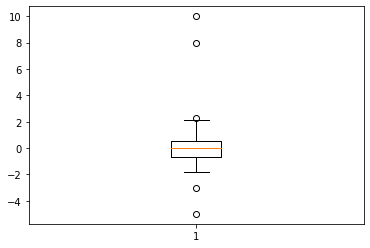

In [238]:
# box plt 생성, 확인
fig, ax = plt.subplots()
ax.boxplot(data)
plt.show()

In [239]:
## IQR을 구하기 위해 우선 제1사분위수와 제 3사분위수를 구합니다.

Q3, Q1 = np.percentile(data, [75 ,25])
IQR = Q3 - Q1
IQR

1.1644925829790964

In [240]:
# IQR과 제 1사분위수, 제 3사분위수를 이용하여 이상치를 확인
data[(Q1-1.5*IQR > data)|(Q3+1.5*IQR < data)]

array([ 2.31256634,  8.        , 10.        , -3.        , -5.        ])

In [241]:
# 로버스트(robust)하다 :: 아상치에 대해 강건하다
# Q. 사분위 범위수를 이용해서 이상치를 찾는 outlier2() 함수를 구현해보세요.
def outlier2(df, col):
    # [[YOUR CODE]]
    
    Q3,Q2,Q1 = np.percentile(trade['무역수지'], [75 ,50, 25])
    IQR=Q3-Q1
    
    return df[(Q1-1.5*IQR > df[col])|(Q3+1.5*IQR < df[col])]

outlier2( trade , '무역수지')

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지


## 정규화(Normalization)

In [242]:
# 데이터 단위가 다른 feature (수입건수, 수출건수와 수입금액, 수출금액, 무역수지)
#  스케일이 크게 차이가 나는 데이터

# 정규분포를 따라 랜덤하게 데이터 x를 생성합니다. 
x = pd.DataFrame({'A': np.random.randn(100)*4+4,
                 'B': np.random.randn(100)-1})
x


,A,B
0,6.205792,-1.485248
1,-0.604047,-0.727779
2,3.018785,-0.517099
3,3.323325,-0.414949
4,6.167679,-0.582630
...,...,...
95,5.062917,-1.122239
96,-0.166839,-2.487547
97,-4.230178,0.589513
98,-0.562115,0.779614


In [243]:
# # 데이터 x를 Standardization 기법으로 정규화합니다. 
x_standardization = (x-x.mean())/x.std()
x_standardization

# 데이터 x를 min-max scaling 기법으로 정규화합니다. 
x_min_max = (x-x.min())/(x.max()-x.min())
x_min_max

,A,B
0,0.607216,0.426240
1,0.267692,0.571821
2,0.448318,0.612312
3,0.463502,0.631944
4,0.605316,0.599717
...,...,...
95,0.550235,0.496008
96,0.289490,0.233606
97,0.086901,0.824995
98,0.269782,0.861531


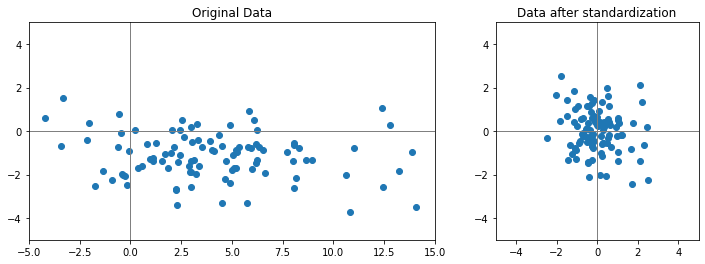

In [244]:
# 다음 이미지는 데이터를 standardization 기법으로 정규화를 했을 때 분포가 어떻게 바뀌는지 보여줍니다. 
# 즉, 각 컬럼의 평균은 0으로, 분산은 1로 데이터를 바꿔줍니다.

fig, axs = plt.subplots(1,2, figsize=(12, 4),
                        gridspec_kw={'width_ratios': [2, 1]})

axs[0].scatter(x['A'], x['B'])
axs[0].set_xlim(-5, 15)
axs[0].set_ylim(-5, 5)
axs[0].axvline(c='grey', lw=1)
axs[0].axhline(c='grey', lw=1)
axs[0].set_title('Original Data')

axs[1].scatter(x_standardization['A'], x_standardization['B'])
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
axs[1].axvline(c='grey', lw=1)
axs[1].axhline(c='grey', lw=1)
axs[1].set_title('Data after standardization')

plt.show()

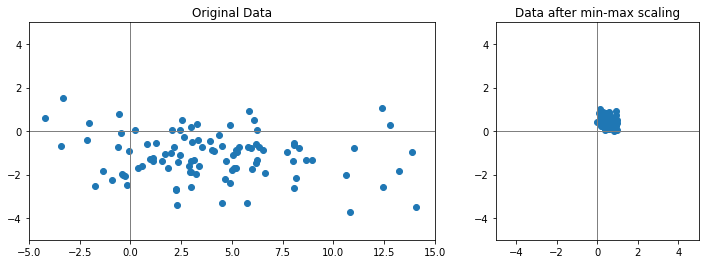

In [245]:
#min-max scaling 기법으로 정규화를 했을 때 분포가 어떻게 바뀌는지 보여줍니다.
#즉, 각 컬럼의 최솟값은 0, 최댓값은 1로 바꿔줍니다.

fig, axs = plt.subplots(1,2, figsize=(12, 4),
                        gridspec_kw={'width_ratios': [2, 1]})

axs[0].scatter(x['A'], x['B'])
axs[0].set_xlim(-5, 15)
axs[0].set_ylim(-5, 5)
axs[0].axvline(c='grey', lw=1)
axs[0].axhline(c='grey', lw=1)
axs[0].set_title('Original Data')

axs[1].scatter(x_min_max['A'], x_min_max['B'])
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
axs[1].axvline(c='grey', lw=1)
axs[1].axhline(c='grey', lw=1)
axs[1].set_title('Data after min-max scaling')

plt.show()

In [246]:
# trade 
# trade 데이터를 standardization 기법으로 정규화합니다. 
cols = ['수출건수', '수출금액', '수입건수', '수입금액', '무역수지']
trade_standardization = (trade[cols]-trade[cols].mean())/trade[cols].std()
trade_standardization.head()

,수출건수,수출금액,수입건수,수입금액,무역수지
0,-0.007488,1.398195,-0.163593,1.283660,1.254785
1,-0.689278,-0.253687,0.412529,-0.964444,0.399646
2,-0.847838,-1.092048,-0.993148,-0.863844,-1.099018
3,-0.417598,0.852083,-0.576399,0.705292,0.830709
4,-0.764918,-0.390520,0.146306,-1.276341,0.436581


In [247]:
# 각 컬럼의 평균들을 보면 거의 0에 가깝고, 표준편차는 1에 가까운 것을 확인하실 수 있습니다.
trade_standardization.describe()


,수출건수,수출금액,수입건수,수입금액,무역수지
count,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02
mean,-1.093143e-16,-1.366428e-16,1.821904e-17,-5.465713e-17,4.099285e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.194976e-01,-1.232662e+00,-9.984408e-01,-1.276341e+00,-1.604934e+00
25%,-5.937426e-01,-1.042227e+00,-7.673625e-01,-7.911669e-01,-1.118002e+00
50%,-4.373265e-01,-1.573034e-01,-3.429346e-01,-4.137392e-01,1.674603e-01
75%,4.420459e-01,1.036441e+00,3.927781e-01,8.827841e-01,7.446755e-01
max,5.486317e+00,2.077723e+00,3.239068e+00,2.376092e+00,2.432393e+00


In [250]:
# Min-Max Scaling
# Q. trade 데이터를 min-max scaling 기법으로 정규화합니다.
# 각 컬럼의 최솟값(min)은 0이고, 최댓값(max)은 1임을 확인
    
trade[cols] =  trade[['수출건수', '수출금액', '수입건수', '수입금액', '무역수지']]

#cols = ['수출건수', '수출금액', '수입건수', '수입금액', '무역수지']



In [251]:
trade = (trade[cols]-trade[cols].min() )/(trade[cols].max()- trade[cols].min())
trade.head()

,수출건수,수출금액,수입건수,수입금액,무역수지
0,0.142372,0.794728,0.197014,0.700903,0.708320
1,0.035939,0.295728,0.332972,0.085394,0.496512
2,0.011187,0.042477,0.001249,0.112938,0.125310
3,0.078351,0.629759,0.099597,0.542551,0.603281
4,0.024131,0.254394,0.270146,0.000000,0.505660


In [252]:

trade.describe()

,수출건수,수출금액,수입건수,수입금액,무역수지
count,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.143541,0.372362,0.235620,0.349450,0.397524
std,0.156108,0.302080,0.235988,0.273790,0.247689
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050853,0.057527,0.054532,0.132836,0.120608
50%,0.075271,0.324844,0.154691,0.236172,0.439002
75%,0.212548,0.685450,0.328311,0.591147,0.581972
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [270]:
## 정규화는 test train 동일하게

train = pd.DataFrame([[10, -10], [30, 10], [50, 0]])
test = pd.DataFrame([[0, 1], [10, 10]])

In [271]:

# Q. train 데이터와 test 데이터에 정규화를 적용해봅시다.
train_min = train.min()
train_max = train.max()

# 중요한 점은, test 데이터에 min-max scaling을 적용할 때도
# train 데이터 기준으로 수행해야 한다는 것입니다.
#train_min_max =  # [[YOUR CODE]]
# test_min_max =  # [[YOUR CODE]]


train_min_max = (train - train_min )/(train_max- train_min )
test_min_max   = (test - train_min )/(train_max- train_min )


# sklearn MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
train = [[10, -10], [30, 10], [50, 0]]
test = [[0, 1]]

scaler = MinMaxScaler()
scaler.fit_transform(train)
scaler.transform(test)

array([[0. , 0. ],
       [0.5, 1. ],
       [1. , 0.5]])

In [272]:
scaler.transform(test)

array([[-0.25,  0.55]])

## 원-핫 인코딩(One-Hot Encoding)

In [275]:
# get_dummies를 통해 국가명 원-핫 인코딩


csv_file_path = os.getenv('HOME')+'/aiffel/data_preprocess/data/trade.csv'
trade = pd.read_csv(csv_file_path) 

country = pd.get_dummies(trade['국가명'])
country.head()


,미국,일본,중국
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,1,0,0


In [278]:
# pd.concat 함수로 데이터프레임 trade와 country 합치기
trade = pd.concat([trade, country], axis=1)
trade.head()

# 국가명 컬럼을 삭제
trade.drop(['국가명'], axis=1, inplace=True)
trade.head()

,기간,수출건수,수출금액,수입건수,수입금액,무역수지,기타사항,미국,일본,중국,미국,일본,중국
0,2015년 01월,116932.0,12083947.0,334522.0,8143271.0,3940676.0,NaN,0,0,1,0,0,1
1,2015년 01월,65888.0,5561545.0,509564.0,3625062.0,1936484.0,NaN,1,0,0,1,0,0
2,2015년 01월,54017.0,2251307.0,82480.0,3827247.0,-1575940.0,NaN,0,1,0,0,1,0
3,2015년 02월,86228.0,9927642.0,209100.0,6980874.0,2946768.0,NaN,0,0,1,0,0,1
4,2015년 02월,60225.0,5021264.0,428678.0,2998216.0,2023048.0,NaN,1,0,0,1,0,0


## 구간화(Binning)

<AxesSubplot:>

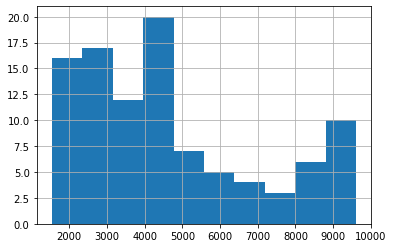

In [280]:
# salary에 소득 데이터

salary = pd.Series([4300, 8370, 1750, 3830, 1840, 4220, 3020, 2290, 4740, 4600, 
                    2860, 3400, 4800, 4470, 2440, 4530, 4850, 4850, 4760, 4500, 
                    4640, 3000, 1880, 4880, 2240, 4750, 2750, 2810, 3100, 4290, 
                    1540, 2870, 1780, 4670, 4150, 2010, 3580, 1610, 2930, 4300, 
                    2740, 1680, 3490, 4350, 1680, 6420, 8740, 8980, 9080, 3990, 
                    4960, 3700, 9600, 9330, 5600, 4100, 1770, 8280, 3120, 1950, 
                    4210, 2020, 3820, 3170, 6330, 2570, 6940, 8610, 5060, 6370,
                    9080, 3760, 8060, 2500, 4660, 1770, 9220, 3380, 2490, 3450, 
                    1960, 7210, 5810, 9450, 8910, 3470, 7350, 8410, 7520, 9610, 
                    5150, 2630, 5610, 2750, 7050, 3350, 9450, 7140, 4170, 3090])

salary.hist()

In [281]:
# pandas cut() 함수 사용
## cut은 구간을 일정하게 나누는 것이 아니라 데이터의 분포를 비슷한 크기의 그룹
bins = [0, 2000, 4000, 6000, 8000, 10000]


In [286]:
ctg = pd.cut(salary, bins=bins)
ctg  # salary[0]는 4300으로 4000에서 6000 사이에 포함되었다는 것을 확인


0      (4000, 6000]
1     (8000, 10000]
2         (0, 2000]
3      (2000, 4000]
4         (0, 2000]
          ...      
95     (2000, 4000]
96    (8000, 10000]
97     (6000, 8000]
98     (4000, 6000]
99     (2000, 4000]
Length: 100, dtype: category
Categories (5, interval[int64, right]): [(0, 2000] < (2000, 4000] < (4000, 6000] < (6000, 8000] < (8000, 10000]]

In [288]:
print('salary[0]:', salary[0])
print('salary[0]가 속한 카테고리:', ctg[0])

# 구간별 데이터 갯수
ctg.value_counts().sort_index()

# 구간의 갯수를 정해서 구간을 나눌수도 있다.
bins = 6
ctg = pd.cut(salary, bins=bins)

ctg.value_counts().sort_index()

salary[0]: 4300
salary[0]가 속한 카테고리: (4000, 6000]


(0, 2000]        12
(2000, 4000]     34
(4000, 6000]     29
(6000, 8000]      9
(8000, 10000]    16
dtype: int64

In [289]:
# pandas qcut() 함수 사용

ctg = pd.qcut(salary, q=5)
ctg

0       (3544.0, 4648.0]
1       (7068.0, 9610.0]
2     (1539.999, 2618.0]
3       (3544.0, 4648.0]
4     (1539.999, 2618.0]
             ...        
95      (2618.0, 3544.0]
96      (7068.0, 9610.0]
97      (7068.0, 9610.0]
98      (3544.0, 4648.0]
99      (2618.0, 3544.0]
Length: 100, dtype: category
Categories (5, interval[float64, right]): [(1539.999, 2618.0] < (2618.0, 3544.0] < (3544.0, 4648.0] < (4648.0, 7068.0] < (7068.0, 9610.0]]

In [290]:
print(ctg.value_counts().sort_index())
print(".\n.\n🛸 Well done!")

(1539.999, 2618.0]    20
(2618.0, 3544.0]      20
(3544.0, 4648.0]      20
(4648.0, 7068.0]      20
(7068.0, 9610.0]      20
dtype: int64
.
.
🛸 Well done!


## 퀴즈  

https://lms.aiffel.io/course/945/node/1089/step/6845